# Machine Learning
## Miniproject 2
Dragi Kamov and Aadil Kumar

## Used libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as la
from sklearn.decomposition import PCA

## Loading data

In [2]:
vectors = np.loadtxt('data/mfeat-pix.txt')
ones = vectors[200:400]

## Visualization functions

In [3]:
def showImage(vectors):
    imageMatrix = vectors.reshape(16, 15)
    plt.imshow(imageMatrix, cmap = 'gray')
    plt.show()
    
def multImage(vectors): 
    for rows in vectors: 
        showImage(rows)

## Feature extraction 
Feature extraction is a dimensionality reduction process used in machine learning to derive values (features) that are important from a dataset and thus reduce it to more manageable groups for processing.

## Types of features 
There are three main types of features and those are:
- K-means based features are features that group a collection of data points into related clusters $ C_1, ..., C_K $, each of them being represented by a codebook vector $ c_i $.
- Hand-made features are referring to properties derived from human insight on information that is in the images.
- Principal Component Analysis (PCA) is a feature that reduces the dimensionality of a data set consisting of many variables correlated with each other, while retaining the variation present in the dataset, up to the maximum extent.

In this assignment we will use PCA for feature extraction.
### Steps for principal component analysis (PCA):

1. Prepare the data (standardization):
    - Center the data: subtract the mean from each variable. This produces a data set whose mean is zero.
    - Scale the data: If the variances of the variables in your data are significantly different, it's a good idea to scale the data to unit variance. This is achieved by dividing each variables by its standard deviation.
2. Calculate the covariance/correlation matrix
3. Compute SVD of the covariance/correlation matrix
4. Compute the new dataset
    - We need to compress and decompress the data using the principle component
    - And then in order to compute the new dataset we need to recover from the standardization

In [4]:
def standardization(data):
    # standardization of the data set
    mean = np.sum(data, axis = 0)
    N, _ = data.shape
    mean = mean / float(N)
    mean_mat = [mean] * N
    standardized = data - mean_mat
    return standardized, mean

def destandardization(standardized, mean):
    # recover from the standardization
    N, _ = standardized.shape
    mean_mat = [mean] * N
    data = standardized + mean_mat
    return data

In [5]:
def compress(standardized, pc, k):
    # compress the standardized data using the princle component, pc
    pc = pc[:, :k]
    return np.matmul(standardized, pc)

def decompress(compressed, pc, k):
    # recover from compression
    pc = pc[:, :k]
    return np.matmul(compressed, pc.T)

In [6]:
def pca(data, k):
    # first standardize the data
    standardized_data, mean_data = standardization(data)

    # calculate the covariance/correlation matrix
    R = np.corrcoef(standardized_data.T)

    # compute the SVD
    u, s, _ = la.svd(R)
    return decompress(compress(standardized_data, u, k), u, k), mean_data

An example of PCA with k = 4 on the digit 1 from the dataset would look like this:

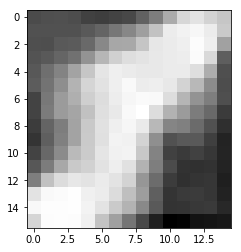

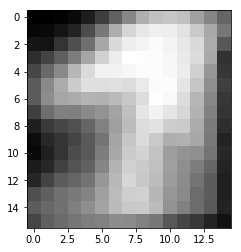

In [7]:
pca_data, mean_data = pca(ones, 4)
multImage(destandardization(pca_data, mean_data)[:2])

An example of PCA with k = 199 on the same dataset

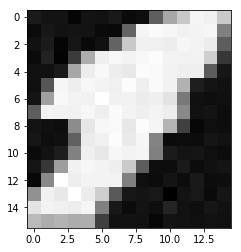

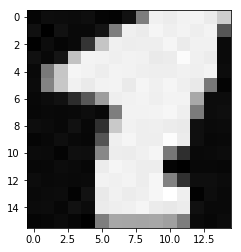

In [8]:
pca_data, mean_data = pca(ones, 199)
multImage(destandardization(pca_data, mean_data)[:2])

## Adding bias

A function to add a bias term to all the features. Linear Regression creates a model based on a offine function, which contains a bias term. Without the bias term we can only approximate the data using a linear function, leading to a ineffective model.

In [9]:
def addBias(dataset):
    R, C = dataset.shape
    biased = np.ones((R, C + 1))
    biased[:,:-1] = dataset
    return biased

def squareNorm(val):
    return np.sum(np.power(val, 2))

## Use One-hot encoding to generate class vector
Since the dataset doesn't contain any kind of label, we need to generate a class vector for each label $\{0, 1, 2, ... 10\}$ as $v \in \mathbb{R}^{10}$. The following function will execute such a strategy.

In [10]:
def oneHotEncode(digit):
    encoded = np.zeros(10)
    encoded[digit] = 1
    return encoded

# Linear Regression Implementation
For a given dataset $vectors$ and a fixed number of feature $k$, our linear regression algorithm executes with the following steps:
1. Executes the PCA algorithm to reduce the dimensionality of $vectors$ from $\mathbb{R}^{240}$ to $\mathbb{R}^{k}$. Thus, we can view PCA algorithms as a function $PCA: \mathbb{R}^{240} \to \mathbb{R}^{k}$
2. Splits the entire dataset into a training set with features $X \in \mathbb{R}^{1000 \times k}$ and a test set with features $X_{test} \in \mathbb{R}^{1000 \times k}$
3. Adds bias terms to $X$ and $X_{test}$, giving us $X, X_{test} \in \mathbb{R}^{1000 \times (K + 1)}$ 
4. Creates the class vectors for the training set as $Y \in \mathbb{R}^{(k + 1) \times 10}$ and the test set as $Y_{test} \in \mathbb{R}^{(k + 1) \times 10}$. We then obtain the training set as $(X, Y)$ and the test set as $(X_{test}, Y_{test})$
5. Using the training set, it computes the optimal weight matrix as
$$ {W_{opt}}^\top = (\frac{1}{N} \cdot X^\top \cdot X + \alpha^2 \cdot I_{nxn})^{-1} \cdot \frac{1}{N} \cdot X^\top \cdot Y $$
which we can rewrite as
$$ W_{opt} = ((\frac{1}{N} \cdot X^\top \cdot X + \alpha^2 \cdot I_{nxn})^{-1} \cdot \frac{1}{N} \cdot X^\top \cdot Y)^\top $$
6. Calculates the error term by,
First, making a prediction:
$$ Y_{pred} = (W_{opt} \cdot X^\top)^\top $$
$$ Y_{test}pred = (W_{opt} \cdot {X_{test}}^\top)^\top $$
Using the prediction, to calculate the corresponding error
$$ MSE_{train} = \frac{\|Y - Ypred\|^2}{1000} $$
$$ MSE_{test} = \frac{\|Ytest - Y_{test}pred\|^2}{1000} $$
$$ MISS_{train} = \frac{\sum_{i = 1}^{1000} \min(1, \|\arg\max(Y_i) - \arg\max(Ypred_i)\|)}{1000} $$
$$ MISS_{test} = \frac{\sum_{i = 1}^{1000} \min(1, \|\arg\max({Y_{test}}_i) - \arg\max(Y_{test}pred_i)\|)}{1000} $$

In [11]:
def linearRegression(data, k):
    
    # Executing PCA
    pca = PCA(n_components=k)
    data_pca = pca.fit_transform(data)
    
    # Splitting the training set
    X = np.ones((1000, k))
    Xtest = np.ones((1000, k))
    
    for i in range(10):
        X[i * 100 : i * 100 + 100][:] = data_pca[i * 200 : i * 200 + 100][:]
        Xtest[i * 100 : i * 100 + 100][:] = data_pca[i * 200 + 100 : i * 200 + 200][:]
    
    # Adding bias terms
    X = addBias(X)
    Xtest = addBias(Xtest)
    
    # Creating the class
    Y = np.zeros((1000, 10))
    Ytest = np.zeros((1000, 10))
    
    for i in range(1000):
        digit = i // 100
        # One-hot encoding
        Y[i] = oneHotEncode(digit).T 
        Ytest[i] = oneHotEncode(digit).T 
        
    # Calc optimal weight
    left = la.inv((1/1000) * np.matmul(X.T, X) + (0 * np.eye(k + 1))) * (1/1000)
    right = np.matmul(X.T, Y)
    Wopt = (np.dot(left,right)).T
    
    # Calc training error term
    # Making a prediction initially
    Ypred = np.matmul(Wopt, X.T).T
    Ytestpred = np.matmul(Wopt, Xtest.T).T
    
    # Calc error
    mse_train = squareNorm(Ypred - Y) / 1000.0
    num_miss_train = 0

    for i in range(1000):
        if np.argmax(Ypred[i]) != np.argmax(Y[i]):
            num_miss_train = num_miss_train + 1
    miss_train = num_miss_train / 1000.0
    
    mse_test = squareNorm(Ytestpred - Ytest) / 1000.0
    num_miss_test = 0
    
    for i in range(1000):
        if np.argmax(Ytestpred[i]) != np.argmax(Ytest[i]):
            num_miss_test = num_miss_test + 1
            
    miss_test = num_miss_test / 1000.0
    
    return Wopt, mse_train, miss_train, mse_test, miss_test

In [12]:
_, mse_train, miss_train, mse_test, miss_test = linearRegression(vectors, 40)
print("MSE Train =", mse_train, ", Miss Train =", miss_train, ", MSE Test =", mse_test, ", Miss Test =",miss_test)

MSE Train = 0.303979701899785 , Miss Train = 0.053 , MSE Test = 0.3218656395527205 , Miss Test = 0.057


# Plotting the k and the errors
We variate k and check to see how the error changes
1. First, plot the data using linear scaling

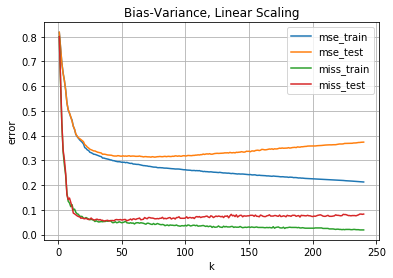

In [13]:
# Plotting the k and the errors
ks = []
mse_trains = []
miss_trains = []
mse_tests = []
miss_tests = []
for k in range(1, 241):
    _, mse_train, miss_train, mse_test, miss_test = linearRegression(vectors, k)
    ks.append(k)
    mse_trains.append(mse_train)
    miss_trains.append(miss_train)
    mse_tests.append(mse_test)
    miss_tests.append(miss_test)

plt.xlabel('k')
plt.ylabel('error')
plt.title('Bias-Variance, Linear Scaling')
plt.grid(True)
p1, = plt.plot(ks, mse_trains, label = 'mse_train')
p2, = plt.plot(ks, mse_tests, label = 'mse_test')
p3, = plt.plot(ks, miss_trains, label = 'miss_train')
p4, = plt.plot(ks, miss_tests, label = 'miss_test')
plt.legend(handles=[p1, p2, p3, p4])
plt.show()

2. Then, use log-log scaling of the data

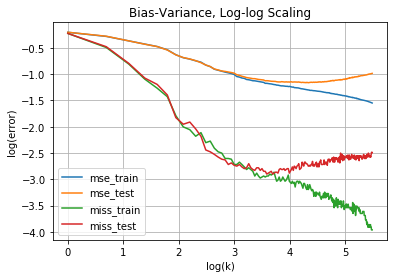

In [14]:
# Log plot
plt.xlabel('log(k)')
plt.ylabel('log(error)')
plt.title('Bias-Variance, Log-log Scaling')
plt.grid(True)
p1, = plt.plot(np.log(ks), np.log(mse_trains), label = 'mse_train')
p2, = plt.plot(np.log(ks), np.log(mse_tests), label = 'mse_test')
p3, = plt.plot(np.log(ks), np.log(miss_trains), label = 'miss_train')
p4, = plt.plot(np.log(ks), np.log(miss_tests), label = 'miss_test')
plt.legend(handles=[p1, p2, p3, p4])
plt.show()

In [15]:
_, mse_train, miss_train, mse_test, miss_test = linearRegression(vectors, 1)
print("MSE Train =", mse_train, ", Miss Train =", miss_train, ", MSE Test =", mse_test, ", Miss Test =",miss_test)

MSE Train = 0.8172359115739828 , Miss Train = 0.8 , MSE Test = 0.8178985003684022 , Miss Test = 0.8


In [16]:
_, mse_train, miss_train, mse_test, miss_test = linearRegression(vectors, 240)
print("MSE Train =", mse_train, ", Miss Train =", miss_train, ", MSE Test =", mse_test, ", Miss Test =",miss_test)

MSE Train = 0.21269006612474484 , Miss Train = 0.019 , MSE Test = 0.3738118732873061 , Miss Test = 0.083


In [17]:
_, mse_train, miss_train, mse_test, miss_test = linearRegression(vectors, 36)
print("MSE Train =", mse_train, ", Miss Train =", miss_train, ", MSE Test =", mse_test, ", Miss Test =",miss_test)

MSE Train = 0.30958408963762035 , Miss Train = 0.053 , MSE Test = 0.3248403433488668 , Miss Test = 0.056
